In [183]:
import matplotlib.pyplot as plt

from enum import Enum
from functools import cache
from random import choice

In [41]:
class Dir(Enum):
    U = 0
    R = 1
    D = 2
    L = 3

In [188]:
list(Dir)

[<Dir.U: 0>, <Dir.R: 1>, <Dir.D: 2>, <Dir.L: 3>]

In [51]:
def valid_coords(coords: tuple[int, int], size: int) -> bool:
    i, j = coords
    return i >= 0 and i < size and j >= 0 and j < size

In [260]:
class Node:
    i: int
    j: int
    size: int

    children: list[Node]

    def __init__(self, i, j, size):
        self.i, self.j = i, j
        self.size = size
        self.children = []

    def __repr__(self):
        return f"Node({self.i}, {self.j}, {self.size})"

    def __eq__(self, o) -> bool:
        if isinstance(o, tuple):
            return (self.i, self.j) == o
        elif isinstance(o, type(self)):
            return self.i == o.i and self.j == o.j
        return False

    def __hash__(self) -> int:
        return hash((self.i, self.j))

    @property
    @cache
    def walls(self) -> list[bool]:
        walls = []
        for dirn in Dir:
            neighbor = self.get_neighbor_coords(dirn)
            walls.append(neighbor not in self.children)
        if self.i == 0:
            walls[Dir.U.value] = True
        if self.i == self.size - 1:
            walls[Dir.D.value] = True
        if self.j == 0:
            walls[Dir.L.value] = True
        if self.j == self.size - 1:
            walls[Dir.R.value] = True
        return walls

    def to_xy(self) -> tuple[i, j]:
        return self.j, self.size - self.i

    def get_neighbor_coords(self, dirn: Dir) -> tuple[int, int]:
        match dirn:
            case Dir.U:
                return self.i - 1, self.j
            case Dir.R:
                return self.i, self.j + 1
            case Dir.D:
                return self.i + 1, self.j
            case Dir.L:
                return self.i, self.j - 1

    def choose_neighbor(self, existing_nodes: dict[Node, Node]) -> Node | None:
        possible_dirs = []
        for dirn in Dir:
            coords = self.get_neighbor_coords(dirn)
            if valid_coords(coords, self.size) and coords not in existing_nodes:
                possible_dirs.append(coords)
        if len(possible_dirs) == 0:
            return None
        neighbor_coords = choice(possible_dirs)
        return Node(*neighbor_coords, self.size)

In [309]:
class Maze:
    size: int
    dfs_start: Node
    nodes: dict[Node, Node]
    start: Node
    end: Node

    def __init__(self, size: int):
        self.size = size
        self.nodes = {}
        self._create()

    def _create(self):
        opts = list(range(self.size))
        node = Node(choice(opts), choice(opts), self.size)
        self.dfs_start = node
        self.nodes[node] = node

        path = []
        while len(self.nodes) < self.size ** 2:
            neighbor = node.choose_neighbor(self.nodes)
            if neighbor is None:
                # go back up the path to find a new node with untraversed neighbors
                node = path[-1]
                path = path[:-1]
            else:
                path.append(node)
                node.children.append(neighbor)
                neighbor.children.append(node)
                self.nodes[neighbor] = neighbor
                node = neighbor

        self.start, self.end = self._choose_endpoints()

    def _choose_endpoints(self) -> tuple[Node, Node]:
        opts = list(range(self.size))
        s_edge, e_edge = choice(list(Dir)), choice(list(Dir))
        s_other, e_other = choice(opts), choice(opts)
        nodes = []
        for edge, other in [(s_edge, s_other), (e_edge, e_other)]:
            match edge:
                case Dir.U:
                    coords = [0, other]
                case Dir.R:
                    coords = [other, self.size - 1]
                case Dir.D:
                    coords = [self.size - 1, other]
                case Dir.L:
                    coords = [other, 0]
            nodes.append(self.nodes[tuple(coords)])
        return tuple(nodes)

    def show(self, show_dfs_start = True):
        ratio = self.size / 20
        w, h = ratio * 6.4, ratio * 4.8

        fig, ax = plt.subplots(dpi=200)
        fig.set_figwidth(w)
        fig.set_figheight(h)

        if show_dfs_start:
            x, y = self.dfs_start.to_xy()
            ax.scatter([x + 0.5], [y + 0.5], color="red")

        for n, c in [(self.start, "blue"), (self.end, "green")]:
            x, y = n.to_xy()
            ax.scatter([x + 0.5], [y + 0.5], color=c)

        for i in range(self.size):
            for j in range(self.size):
                node = self.nodes[(i, j)]
                x, y = node.to_xy()
                for dirn in Dir:
                    if node.walls[dirn.value]:
                        match dirn:
                            case Dir.U:
                                ax.plot([x, x + 1], [y + 1, y + 1], color="black")
                            case Dir.R:
                                ax.plot([x + 1, x + 1], [y, y + 1], color="black")
                            case Dir.D:
                                ax.plot([x, x + 1], [y, y], color="black")
                            case Dir.L:
                                ax.plot([x, x], [y, y + 1], color="black")

        ax.set_axis_off()

        plt.show()

In [310]:
m = Maze(46)

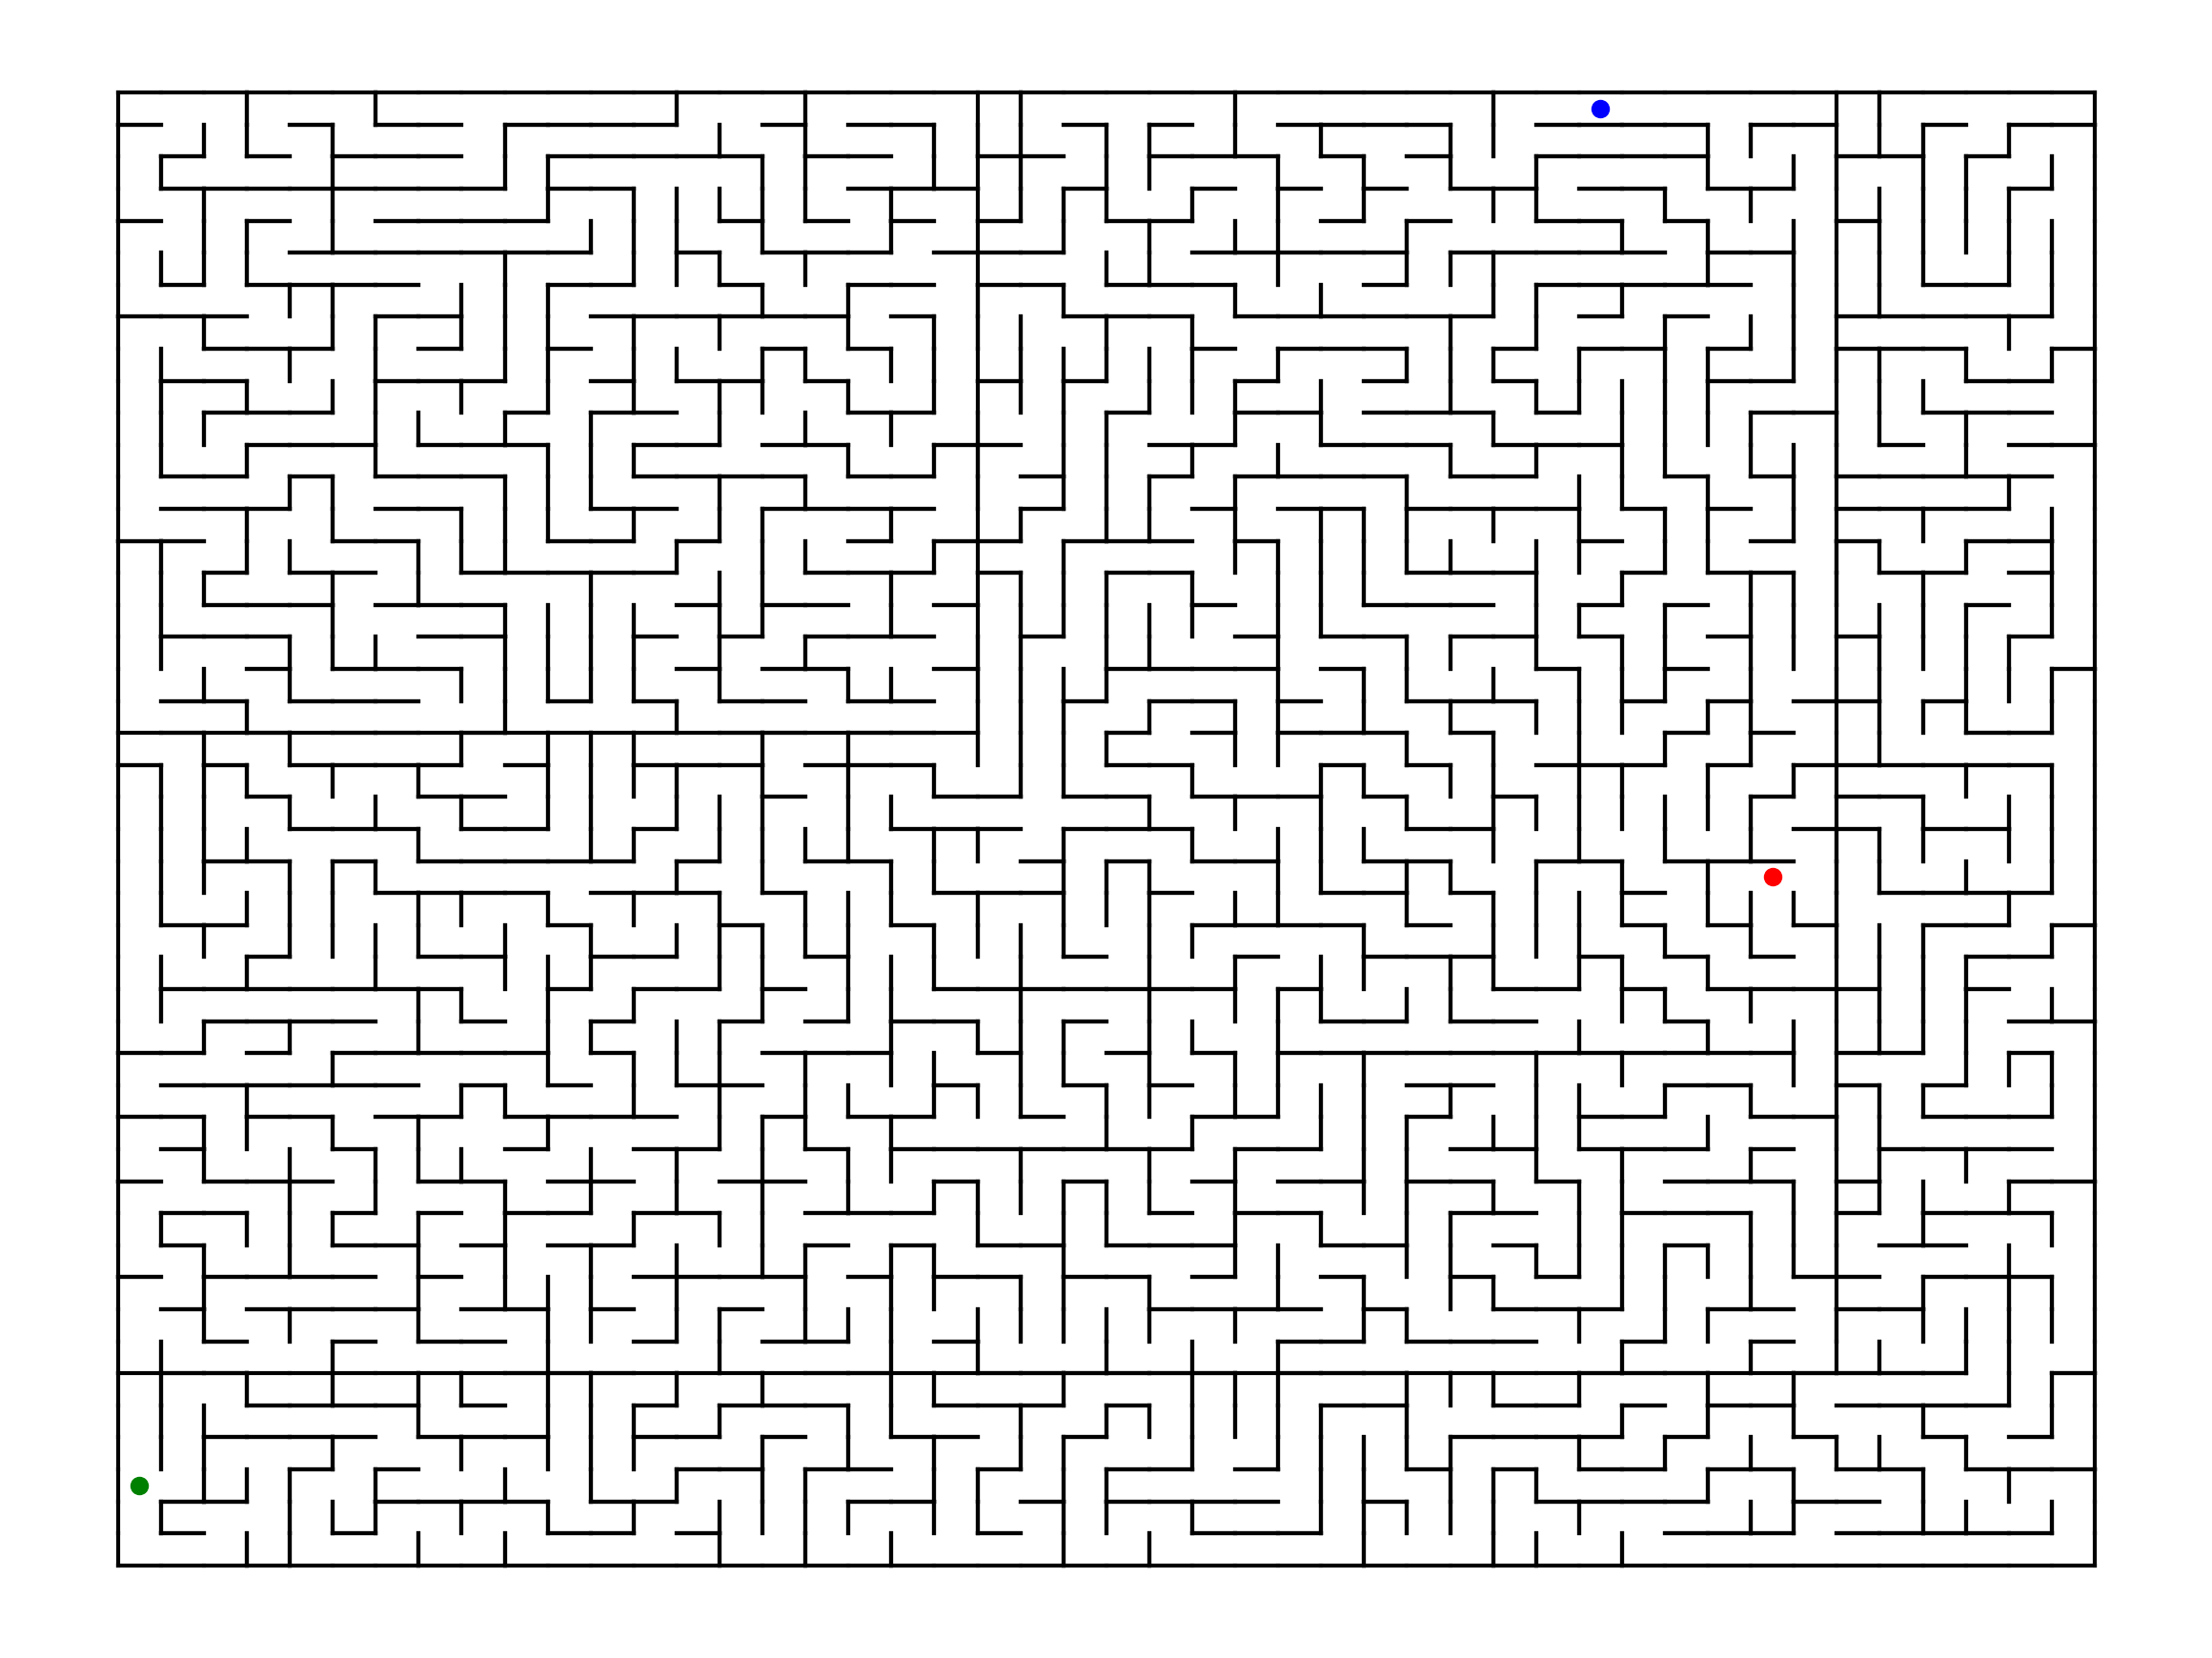

In [311]:
m.show()